# RP-GPFA: multifactorial (video + range sensor) integration


3 agents navigate in a bounded environment. Their locations are observed in the form of 3D-rendered image frames
and range-finding sensor data giving the distances of one of the agents from the four corners of the room
 (slightly differs from original [paper](https://arxiv.org/abs/2209.05661) for compactness).

In this setting, a (2D) latent inducing conditional independence should recover the location of the
range-finder-equipped agent, ignoring the other agents and the rest of the image data.

RP-GPFA learns:

1. the nonlinear mapping from distance to position signal

2. to track a moving agent

3. which agent to track amongst the distractors.

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import imageio
import pickle
from recognition_parametrised_gpfa import RPGPFA
from utils_process import plot_summary, plot_factors_prior, plot_loss

from utils import diagonalize

Build / Load Dataset

In [2]:
# Reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Problem Dimensions
num_observation = 10
num_inducing = 50
len_snippet = 100
dim_latent = 2

# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

# Pre-Stored "Videos"
trajectory_folder = '../RPGPFA_demo_data/videos_rpm/'
trajectory_name = 'trajectories_param.pkl'

# Load Trajectories
with open(trajectory_folder + trajectory_name, "rb") as input_file:
        trajectories = pickle.load(input_file)
spatial_trajectories = trajectories['spatial_trajectories']
distance_from_fixed = trajectories['distance_from_fixed']
main_agent = trajectories['main_agent']
video_tensor = trajectories['video_tensor']
main_trajectory = spatial_trajectories[:, main_agent]
latent_true = main_trajectory[:num_observation]
num_observations_full, len_observation, _, _ = video_tensor.shape

Plot typical observation:

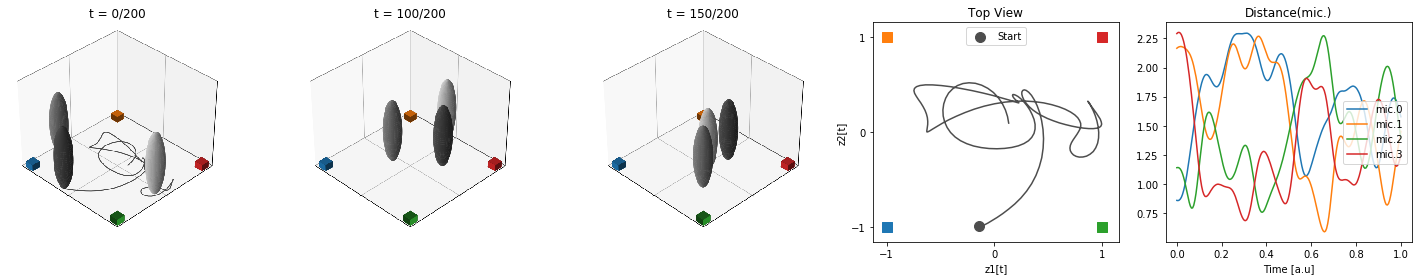

In [3]:
# Plot videos and sound recordings for one observation (if not on GPU)

# Microphone Locations
mic_position = torch.tensor([[-1, -1], [-1, +1], [+1, -1], [+1, +1]], device=device, dtype=data_type)
mic_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# 'Color' of the agents
c1 = [0.8, 0.8, 0.8]
c2 = [0.5, 0.5, 0.5]
c3 = [0.3, 0.3, 0.3]
color_agents = [c1, c2, c3]

obs_eg = 4
tplot = [0, 100, 150]

pheigh = int(np.floor(np.sqrt(len(tplot)+2)))
pwidth = int(np.ceil((len(tplot)+2) / pheigh))

pheigh = 1
pwidth = int(np.ceil((len(tplot) + 2) / pheigh))

plt.figure(figsize=(pwidth * 4, pheigh * 4))

for tt_id in range(len(tplot)):
    name = 'video_' + 'full_plot_n' + str(obs_eg).zfill(3) + '_t' + str(tplot[tt_id]).zfill(4) + '.png'
    im = imageio.imread(trajectory_folder + name)
    #print(name)
    plt.subplot(pheigh, pwidth, tt_id + 1)
    plt.imshow(im)
    plt.imshow(video_tensor[obs_eg, tplot[tt_id]], cmap='gray')

    plt.title('t = ' + str(tplot[tt_id]) + '/' + str(len_observation))
    plt.xlim([75, 550])
    plt.ylim([550, 75])
    plt.axis('off')

plt.subplot(pheigh, pwidth, tt_id + 2)
for ii in range(mic_position.shape[0]):
    plt.scatter(mic_position[ii, 0].cpu(), mic_position[ii, 1].cpu(), s=100, c=mic_colors[ii], marker='s')
plt.plot(main_trajectory[obs_eg, :, 0], main_trajectory[obs_eg, :, 1], c=color_agents[main_agent])
plt.scatter(main_trajectory[obs_eg, 0, 0], main_trajectory[obs_eg, 0, 1], s=100, color=color_agents[main_agent],
            label='Start')
plt.title('Top View')
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.xlabel('z1[t]')
plt.ylabel('z2[t]')
plt.legend()

plt.subplot(pheigh, pwidth, tt_id + 3)
for ii in range(mic_position.shape[0]):
    plt.plot(np.linspace(0, 1, len_observation), distance_from_fixed[obs_eg, :, ii], color=mic_colors[ii],
                label='mic.' + str(ii))
plt.legend(loc=5)
plt.title('Distance(mic.)')
plt.xlabel('Time [a.u]')
plt.tight_layout()

Normalize observation / Init / Fit

In [4]:
def normalize_observations(obs, num_event_dim=1):

    full_dim = obs.shape
    batch_dim = torch.tensor(obs.shape[:num_event_dim])
    event_dim = torch.tensor(obs.shape[num_event_dim:])

    obs = obs.reshape(batch_dim.prod(), event_dim.prod())
    o_mean, o_std = torch.mean(obs, dim=0, keepdim=True), torch.std(obs, dim=0, keepdim=True)
    obs = (obs - o_mean) / (o_std + 1e-6)
    obs = obs.reshape(full_dim)

    return obs

time_locations = torch.arange(0, len_observation, device=device, dtype=data_type).unsqueeze(-1)
inducing_locations = torch.linspace(0, len_observation,   num_inducing, device=device, dtype=data_type)\
    .unsqueeze(-1)

# Build Observed Factors (Transfer to GPU if necessary)
observations1 = torch.tensor(video_tensor[:num_observation, :, 1:][..., 1:-2], device=device, dtype=data_type)
observations1 = (1 - observations1 / observations1.max())
observations2 = torch.tensor(distance_from_fixed[:num_observation], device=device, dtype=data_type)

observations1 = normalize_observations(observations1, num_event_dim=2)
observations2 = normalize_observations(observations2, num_event_dim=2)

# Observation / inducing time locations
observations = (observations1, observations2)
observation_locations = torch.linspace(0, 1, len_observation, device=device, dtype=data_type).unsqueeze(-1)
inducing_locations = torch.linspace(0, 1,   num_inducing, device=device, dtype=data_type).unsqueeze(-1)


fit_params = {'dim_latent': 2,
              'inference_mode': 'VariationalBound',
              'constraint_factors': 'fixed_diag',
              'num_epoch': 20000,
              'optimizer_prior': {'name': 'Adam', 'param': {'lr': 1e-3}},
              'optimizer_factors': {'name': 'Adam', 'param': {'lr': 1e-4}},
              'optimizer_inducing_points': {'name': 'Adam', 'param': {'lr': 1e-3}},
              'gp_kernel': 'RBF',
              'dim_hidden': ([50, 50], [50, 50]), # was all 20
              'nn_type': ('convolutional', 'perceptron'),
              'minibatch_size': len_observation,
              'ergodic': False,
              'pct': 0.1
                }


model = RPGPFA(observations, observation_locations,
               inducing_locations=inducing_locations,
               fit_params=fit_params)

loss_tot = model.fit(observations)



/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RP-GPFA on GPU


/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 2000/20000 Loss: 1.640621e+00
Epoch 4000/20000 Loss: 1.265822e+00
Epoch 6000/20000 Loss: 1.080863e+00
Epoch 8000/20000 Loss: 9.683396e-01
Epoch 10000/20000 Loss: 8.922802e-01
Epoch 12000/20000 Loss: 8.406618e-01
Epoch 14000/20000 Loss: 8.059561e-01
Epoch 16000/20000 Loss: 7.826360e-01
Epoch 18000/20000 Loss: 7.672253e-01
Epoch 20000/20000 Loss: 7.553889e-01


Save model

In [5]:
from save_load import save_gprpm, load_gprpm
fname = './../RPGPFA_demo_results/video_range_sensors.pkl'
save_gprpm(fname, model, observations=observations, true_latent=latent_true)

Load and plot model

RP-GPFA on GPU


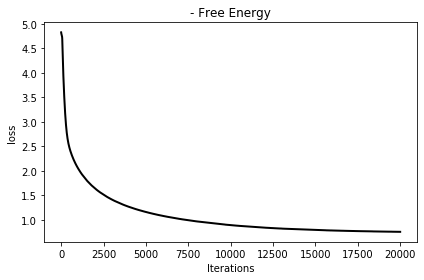

In [6]:
model, obs, latent_true = load_gprpm(fname)
plot_loss(model)

Regress True to discovered latents

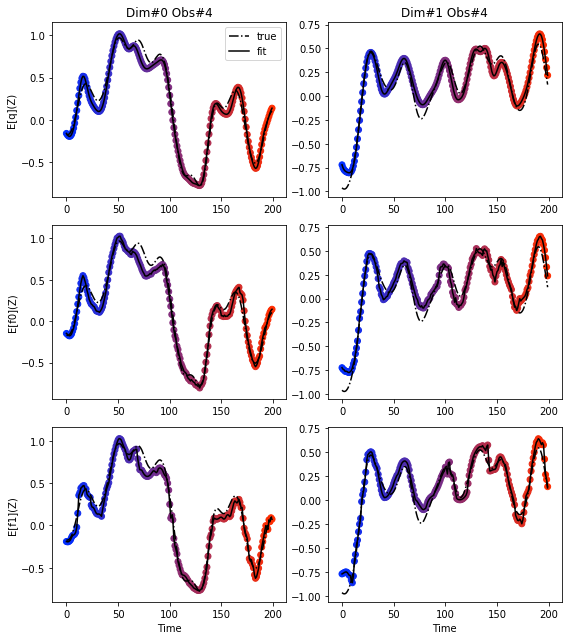

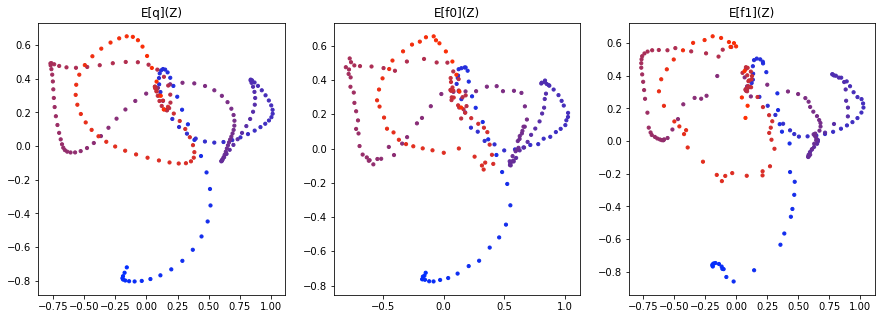

In [15]:
plot_summary(model, latent_true=latent_true, plot_observation=[4], plot_factors_id='all',
             plot_regressed='linear', plot_true=False, regress_param=regress_param)
